In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
df_train = pd.read_csv('data/tmp/df_grouped.csv')
df_test = pd.read_csv('data/tmp/df_grouped_test.csv')
y_train = pd.read_csv('data/tmp/train_y.csv',usecols=['timestamp', 'actualAnomaly'])
y_test = pd.read_csv('data/tmp/test_y.csv',usecols=['timestamp', 'actualAnomaly'])

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
y_train['timestamp'] = pd.to_datetime(y_train['timestamp'])
y_test['timestamp'] = pd.to_datetime(y_test['timestamp'])

df_combined = pd.concat([df_train, df_test], ignore_index=True)
combined_anomalies = pd.concat([y_train, y_test], ignore_index=True)

df_combined = df_combined.drop(columns=['minute'])
df_combined = df_combined.sort_values(by=['timestamp'],ignore_index=True)
combined_anomalies = combined_anomalies.sort_values(by=['timestamp'],ignore_index=True)
df_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103613 entries, 0 to 103612
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   count         103613 non-null  int64         
 1   timestamp     103613 non-null  datetime64[ns]
 2   dayOfTheWeek  103613 non-null  int64         
 3   isWeekend     103613 non-null  int64         
 4   hours         103613 non-null  int64         
 5   night         103613 non-null  int64         
 6   morning       103613 non-null  int64         
 7   day           103613 non-null  int64         
 8   difference    103613 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 7.1 MB


In [3]:
df_combined

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0
...,...,...,...,...,...,...,...,...,...
103608,25,2023-09-10 23:55:00,6,1,23,0,0,0,7.0
103609,23,2023-09-10 23:56:00,6,1,23,0,0,0,-2.0
103610,17,2023-09-10 23:57:00,6,1,23,0,0,0,-6.0
103611,23,2023-09-10 23:58:00,6,1,23,0,0,0,6.0


# Unsupervised models

In [4]:
#some rough estimation of the anomalies proportion, so we make it a bit higher
print(combined_anomalies['actualAnomaly'].sum() / len(combined_anomalies))
anom_proportion = 0.0008

0.0007431499908312663


## Kmeans

In [5]:
df_kmeans =  df_combined[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]
min_max_scaler = preprocessing.StandardScaler()
df_kmeans = pd.DataFrame(min_max_scaler.fit_transform(df_kmeans), columns=['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference'])
df_kmeans

,count,dayOfTheWeek,isWeekend,hours,night,morning,day,difference
0,-0.633556,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-0.000005
1,0.489346,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,1.216606
2,-0.633556,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-1.216616
3,-0.201670,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,0.467922
4,-0.460801,0.958330,-0.424100,-1.662250,1.733713,-0.577495,-0.57751,-0.280762
...,...,...,...,...,...,...,...,...
103608,0.143838,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,0.655093
103609,-0.028916,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,-0.187176
103610,-0.547179,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,-0.561518
103611,-0.028916,1.454427,2.357936,1.660871,-0.576797,-0.577495,-0.57751,0.561507


In [6]:
pca = PCA(n_components=2)
df_kmeans = pca.fit_transform(df_kmeans)
min_max_scaler = preprocessing.StandardScaler()
df_kmeans = pd.DataFrame(min_max_scaler.fit_transform(df_kmeans))
df_kmeans

,0,1
0,1.602231,0.419180
1,1.118598,0.509098
2,1.743345,0.378897
3,1.416218,0.453764
4,1.582100,0.417520
...,...,...
103608,-0.898972,2.026737
103609,-0.748582,1.991212
103610,-0.547077,1.955909
103611,-0.835422,2.016002


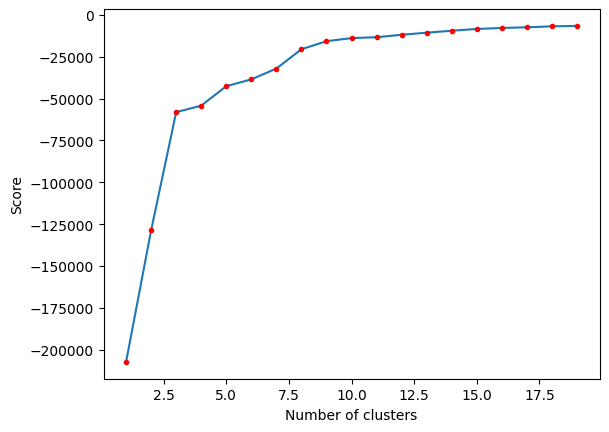

In [7]:
# calculate with different number of centroids to see the loss plot (elbow method)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(df_kmeans) for i in range(1, 20)]
scores = [kmeans[i].score(df_kmeans) for i in range(len(kmeans))]
plt.plot(range(1, 20), scores)
plt.plot(range(1, 20), scores, 'r.')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

In [8]:
df_combined['cluster'] = kmeans[7].predict(df_kmeans)
df_combined['PC1'] = df_kmeans[0]
df_combined['PC2'] = df_kmeans[1]
df_combined['cluster'].value_counts()

cluster
0    20358
7    18968
4    13823
3    12856
2    11852
1    11057
5    10752
6     3947
Name: count, dtype: int64

In [9]:
df_combined["distances"] = np.min(kmeans[8].transform(df_kmeans), axis=1)
threshold = np.percentile(df_combined["distances"], 100 * (1 - anom_proportion))

df_combined["KmeansQAnomaly"] = df_combined["distances"].apply(lambda x: int(x > threshold))
df_combined.loc[df_combined["KmeansQAnomaly"] == 1]

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,cluster,PC1,PC2,distances,KmeansQAnomaly
946,62,2023-07-01 15:46:00,5,0,15,0,0,1,19.0,0,-2.070095,0.365268,1.316331,1
979,57,2023-07-01 16:19:00,5,0,16,0,0,1,19.0,0,-1.990901,0.338703,1.232805,1
986,56,2023-07-01 16:26:00,5,0,16,0,0,1,20.0,0,-1.975409,0.337983,1.217942,1
987,63,2023-07-01 16:27:00,5,0,16,0,0,1,7.0,0,-2.018728,0.324427,1.254609,1
1003,57,2023-07-01 16:43:00,5,0,16,0,0,1,19.0,0,-1.990901,0.338703,1.232805,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93172,48,2023-09-03 17:59:00,6,1,17,0,0,1,17.0,2,-1.858274,2.096885,1.237637,1
100328,55,2023-09-08 17:15:00,4,0,17,0,0,1,25.0,0,-2.043975,0.068644,1.225005,1
100842,403,2023-09-09 01:49:00,5,0,1,1,0,0,395.0,2,-12.934551,3.113285,6.972558,1
100843,11,2023-09-09 01:50:00,5,0,1,1,0,0,-392.0,5,5.936549,-0.822071,4.384080,1


In [10]:
anomaly = df_combined.loc[df_combined['KmeansQAnomaly'] == 1, ['timestamp', 'count']]
anomaly.size

166

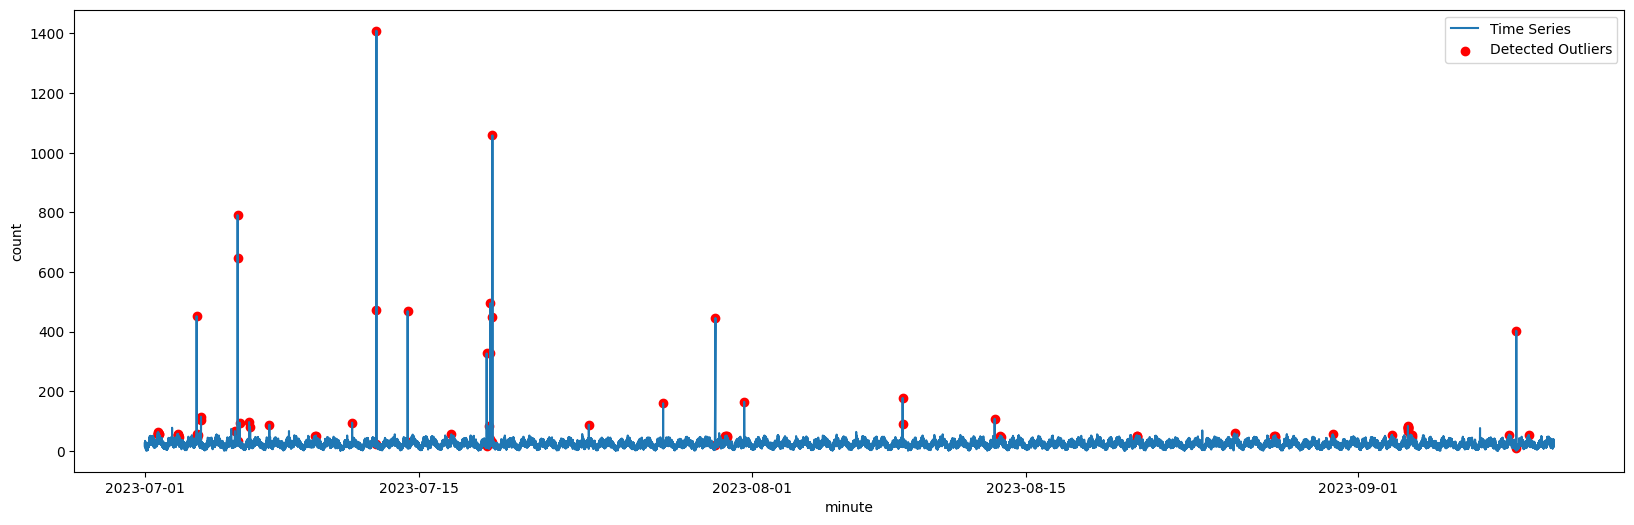

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

In [12]:
df_combined = df_combined.drop(columns=['cluster', 'PC1', 'PC2', 'distances'])
df_combined.head()

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,KmeansQAnomaly
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0,0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0,0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0,0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0,0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0,0


## Gausian model

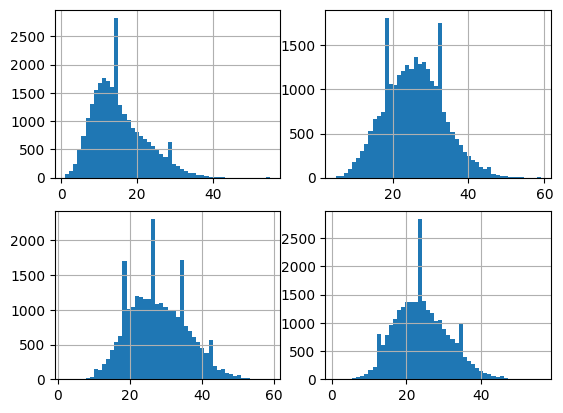

In [13]:
#for easier observation
df_restricted = df_combined.loc[df_combined['count'] < 60]
night = df_restricted.loc[df_restricted['night'] == 1, 'count']
morning = df_restricted.loc[df_restricted['morning'] == 1, 'count']
day = df_restricted.loc[df_restricted['day'] == 1, 'count']
evening = df_restricted.loc[(df_restricted['night'] + df_restricted['morning'] + df_restricted['day'] == 0), 'count']

fig, axs = plt.subplots(2,2)
night.hist(ax=axs[0,0],bins=50)
morning.hist(ax=axs[0,1],bins=50)
day.hist(ax=axs[1,0],bins=50)
evening.hist(ax=axs[1,1],bins=50)
#actual data
night = df_combined.loc[df_combined['night'] == 1, 'count']
morning = df_combined.loc[df_combined['morning'] == 1, 'count']
day = df_combined.loc[df_combined['day'] == 1, 'count']
evening = df_combined.loc[(df_combined['night'] + df_combined['morning'] + df_combined['day'] == 0), 'count']


In [14]:
envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
night_stand = night.values.reshape(-1,1)
envelope.fit(night_stand)
night = pd.DataFrame(night)
night['deviation'] = envelope.decision_function(night_stand)
night['anomaly'] = envelope.predict(night_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
morning_stand = morning.values.reshape(-1,1)
envelope.fit(morning_stand)
morning = pd.DataFrame(morning)
morning['deviation'] = envelope.decision_function(morning_stand)
morning['anomaly'] = envelope.predict(morning_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
day_stand = day.values.reshape(-1,1)
envelope.fit(day_stand)
day = pd.DataFrame(day)
day['deviation'] = envelope.decision_function(day_stand)
day['anomaly'] = envelope.predict(day_stand)

envelope =  EllipticEnvelope(contamination = anom_proportion, random_state = 42) 
evening_stand = evening.values.reshape(-1,1)
envelope.fit(evening_stand)
evening = pd.DataFrame(evening)
evening['deviation'] = envelope.decision_function(evening_stand)
evening['anomaly'] = envelope.predict(evening_stand)

In [15]:
# add the data to the main 
df_gausian = pd.concat([night, morning, day, evening])
df_gausian["anomaly"] = df_gausian["anomaly"].apply(lambda x: 0 if x == 1 else 1) 
df_combined["GausianAnomaly"] = df_gausian["anomaly"]
df_combined.head()

,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,KmeansQAnomaly,GausianAnomaly
0,16,2023-07-01 00:00:00,5,0,0,1,0,0,0.0,0,0
1,29,2023-07-01 00:01:00,5,0,0,1,0,0,13.0,0,0
2,16,2023-07-01 00:02:00,5,0,0,1,0,0,-13.0,0,0
3,21,2023-07-01 00:03:00,5,0,0,1,0,0,5.0,0,0
4,18,2023-07-01 00:04:00,5,0,0,1,0,0,-3.0,0,0


In [16]:
anomaly = df_combined.loc[df_combined['GausianAnomaly'] == 1, ['timestamp', 'count']]
anomaly.shape

(85, 2)

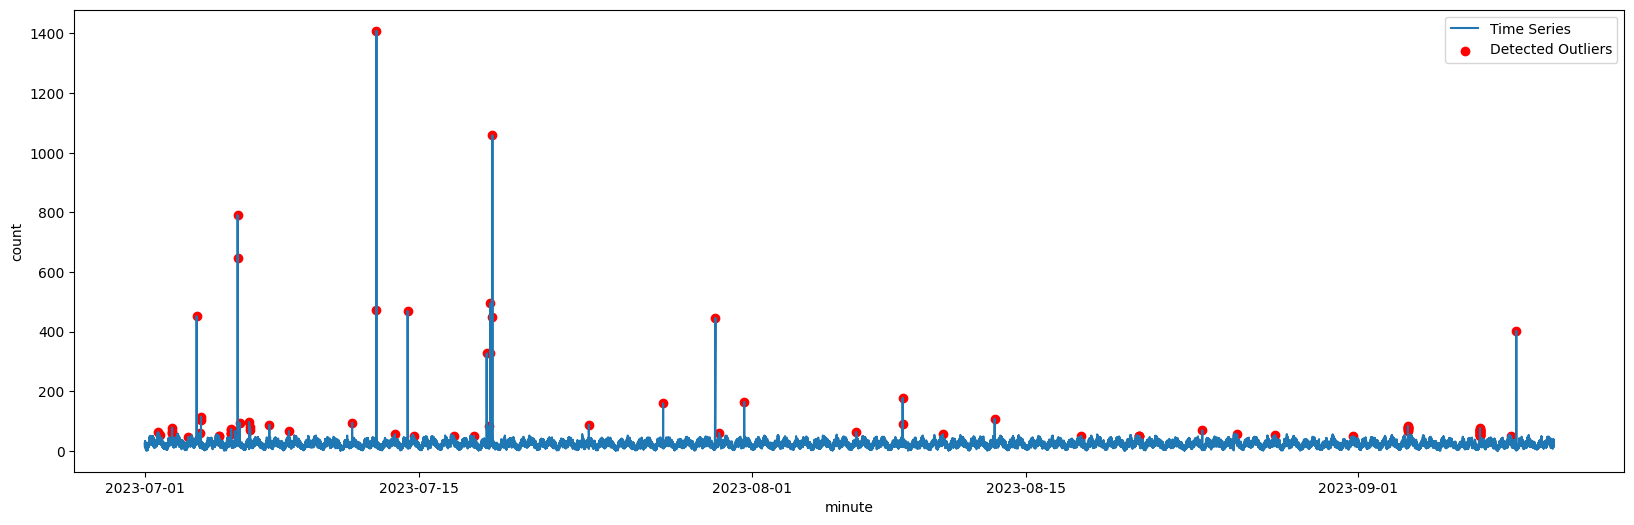

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## Isolation forest

In [24]:
df_iForest =  df_combined[['count','difference']] #'dayOfTheWeek','isWeekend','hours','night','morning','day', - done some experiments, and this combo outperformed others

min_max_scaler = preprocessing.StandardScaler()
df_iForest = min_max_scaler.fit_transform(df_iForest)
df_iForest = pd.DataFrame(df_iForest)

model =  IsolationForest(contamination = anom_proportion, random_state = 42)
model.fit(df_iForest)

df_combined['iForestAnomaly'] = pd.Series(model.predict(df_iForest))
df_combined['iForestAnomaly'] = df_combined['iForestAnomaly'].apply(lambda x: 0 if x == 1 else 1) 
df_combined['iForestAnomaly'].value_counts()



iForestAnomaly
0    103530
1        83
Name: count, dtype: int64

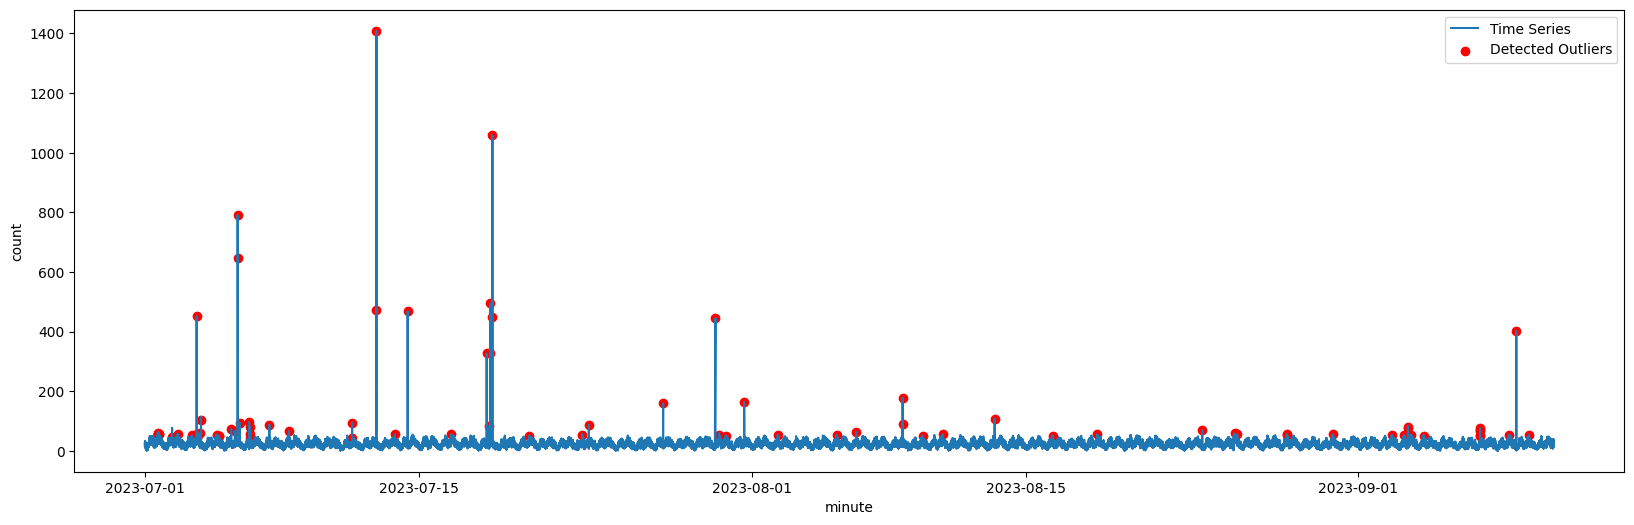

In [25]:
anomaly = df_combined.loc[df_combined['iForestAnomaly'] == 1, ['timestamp', 'count']]
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## One class SVM

In [22]:
df_SVM =  df_combined[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]

min_max_scaler = preprocessing.StandardScaler()
df_SVM = min_max_scaler.fit_transform(df_SVM)
 
model =  OneClassSVM(nu=anom_proportion)
df_SVM = pd.DataFrame(df_SVM)
model.fit(df_SVM)

df_combined['OCSVMAnomaly'] = pd.Series(model.predict(df_SVM))
df_combined['OCSVMAnomaly'] = df_combined['OCSVMAnomaly'].map( {1: 0, -1: 1} )

(89, 2)


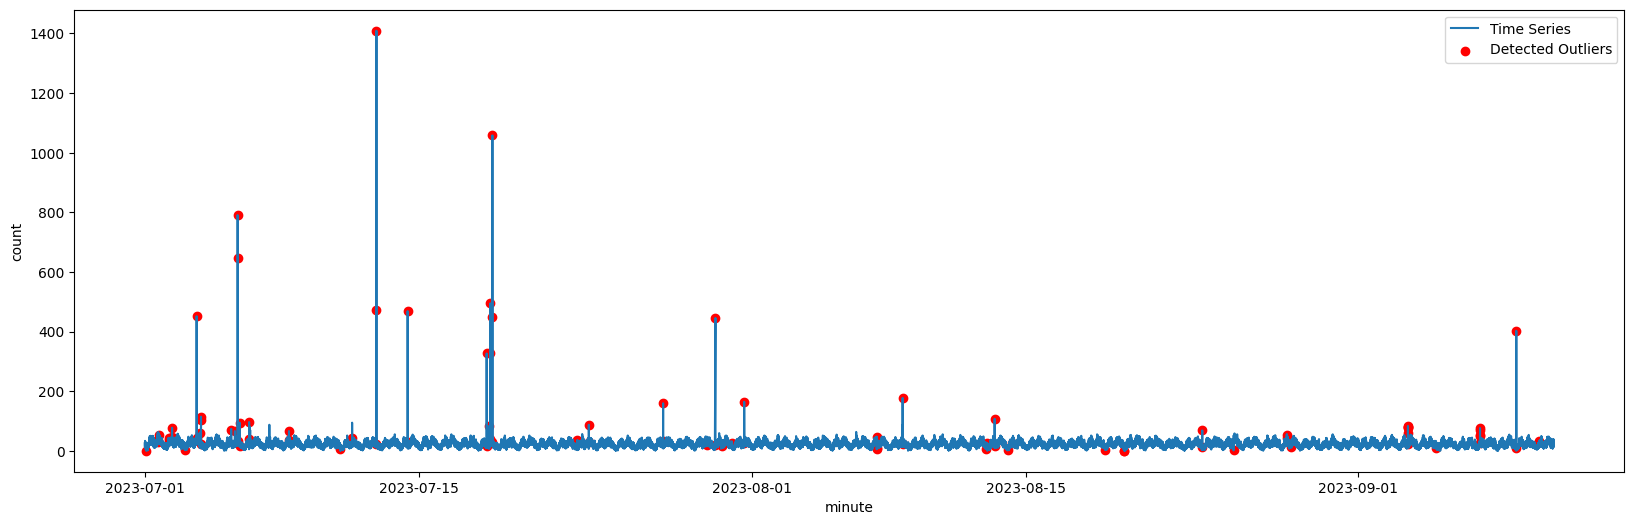

In [23]:
anomaly = df_combined.loc[df_combined['OCSVMAnomaly'] == 1, ['timestamp', 'count']]
print(anomaly.shape)
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## Local outlier factor

In [30]:
df_LOF =  df_combined[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]

min_max_scaler = preprocessing.StandardScaler()
df_LOF = min_max_scaler.fit_transform(df_SVM)

In [31]:
params = {
    'n_neighbors': [20,25,30], #testing the best number of neighbors
    'contamination': [anom_proportion]
}
LOFodel = LocalOutlierFactor()

# Perform grid search with cross-validation on the training data
grid_search = GridSearchCV(LOFodel, params, scoring='f1')
grid_search.fit(df_LOF, combined_anomalies['actualAnomaly'])

best_params = grid_search.best_params_
best_LOF = LocalOutlierFactor(**best_params)
print(best_params)

df_combined['LOFAnomaly'] = pd.Series(best_LOF.fit_predict(df_LOF))
df_combined['LOFAnomaly']

c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 370, in _score
    response_method = _check_

{'contamination': 0.0008, 'n_neighbors': 20}


0         1
1         1
2         1
3         1
4         1
         ..
103608    1
103609    1
103610    1
103611    1
103612    1
Name: LOFAnomaly, Length: 103613, dtype: int32

In [32]:
model =  LocalOutlierFactor(n_neighbors=25, contamination=anom_proportion)
df_LOF = pd.DataFrame(df_LOF)

df_combined['LOFAnomaly'] = pd.Series(model.fit_predict(df_LOF))
df_combined['LOFAnomaly'] = df_combined['LOFAnomaly'].map( {1: 0, -1: 1} )
df_combined['LOFAnomaly'].value_counts()

LOFAnomaly
0    103530
1        83
Name: count, dtype: int64

(83, 2)


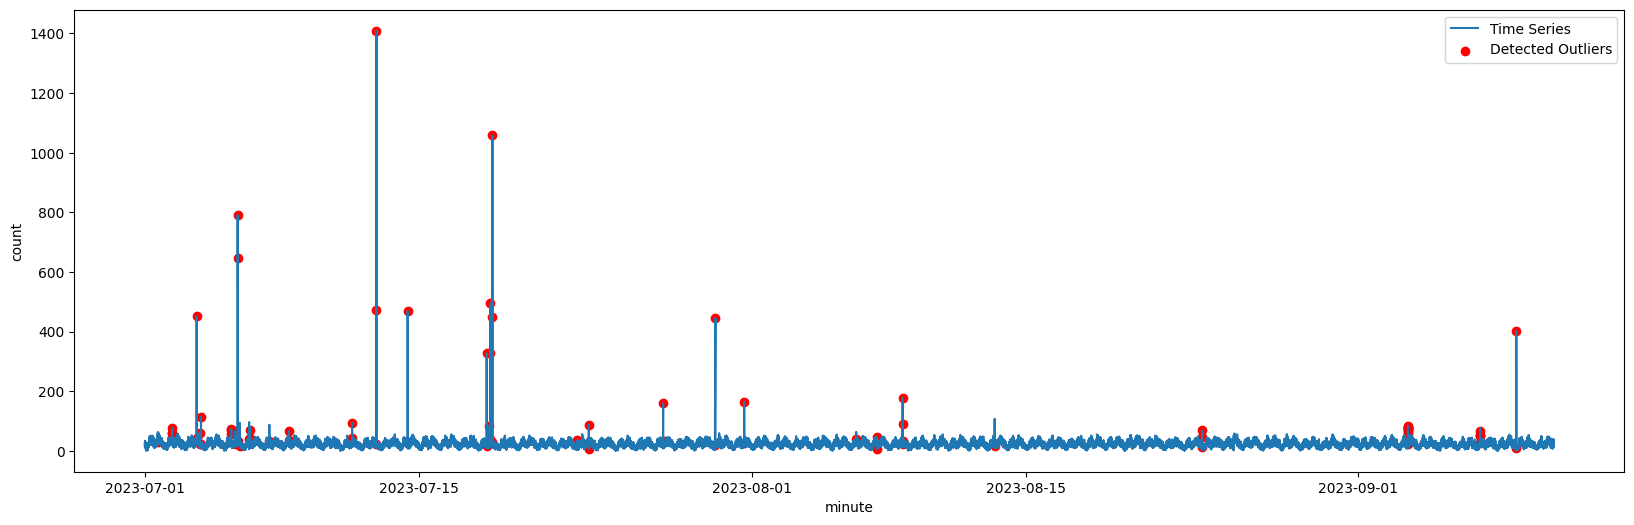

In [33]:
anomaly = df_combined.loc[df_combined['LOFAnomaly'] == 1, ['timestamp', 'count']]
print(anomaly.shape)
plt.figure(figsize=(20, 6))
plt.plot(df_combined['timestamp'], df_combined['count'], label='Time Series')
plt.scatter(anomaly['timestamp'],anomaly['count'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## Accuracy evaluation

In [35]:
# Calculate Precision
for i in ['KmeansQ','Gausian', 'iForest', 'OCSVM', 'LOF']:
    precision = precision_score(combined_anomalies['actualAnomaly'], df_combined[i + 'Anomaly'])
    recall = recall_score(combined_anomalies['actualAnomaly'], df_combined[i + 'Anomaly'])
    f_score = f1_score(combined_anomalies['actualAnomaly'], df_combined[i + 'Anomaly'])
    fpr, tpr, thresholds = roc_curve(combined_anomalies['actualAnomaly'], df_combined[i + 'Anomaly'])
    roc_auc = auc(fpr, tpr)
    print(i, 'models performance:')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", f_score)
    print("ROC AUC: ", roc_auc,end='\n==========================\n')

KmeansQ models performance:
Precision:  0.4457831325301205
Recall:  0.4805194805194805
F-score:  0.4625
ROC AUC:  0.7400375953053283
Gausian models performance:
Precision:  0.6941176470588235
Recall:  0.7662337662337663
F-score:  0.7283950617283951
ROC AUC:  0.882991322925259
iForest models performance:
Precision:  0.46987951807228917
Recall:  0.5064935064935064
F-score:  0.4875
ROC AUC:  0.7530342667686201
OCSVM models performance:
Precision:  0.4157303370786517
Recall:  0.4805194805194805
F-score:  0.4457831325301205
ROC AUC:  0.740008619876492
LOF models performance:
Precision:  0.5180722891566265
Recall:  0.5584415584415584
F-score:  0.5375
ROC AUC:  0.7790276096952036


# Superivsed models

## Logistic Regression

In [36]:
df_LR_train =  df_train[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]
df_LR_test =  df_test[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]

min_max_scaler = preprocessing.StandardScaler()
df_LR_train  = pd.DataFrame(min_max_scaler.fit_transform(df_LR_train))
df_LR_test  = pd.DataFrame(min_max_scaler.fit_transform(df_LR_test))

In [37]:
params = {
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], #testing the best solver
    'random_state': [42]
}
LRmodel = LogisticRegression()

# Perform grid search with cross-validation on the training data
grid_search = GridSearchCV(LRmodel, params, scoring='f1')
grid_search.fit(df_LR_train, y_train['actualAnomaly'])

best_params = grid_search.best_params_
best_LR = LogisticRegression(**best_params)
print(best_params)


c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

{'random_state': 42, 'solver': 'lbfgs'}


c:\Users\lebed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(df_LR_train, y_train['actualAnomaly'])
df_test['LRAnomaly'] = pd.Series(model.predict(df_LR_test))
df_test['LRAnomaly'].value_counts()

LRAnomaly
0    14395
1        5
Name: count, dtype: int64

## KNeighborsClassifier

In [59]:
df_KNN_train =  df_train[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]
df_KNN_test =  df_test[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]

In [60]:
params = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [15, 20, 25]
}
KNNmodel = KNeighborsClassifier()

# Perform grid search with cross-validation on the training data
grid_search = GridSearchCV(KNNmodel, params, scoring='f1')
grid_search.fit(df_KNN_train, y_train['actualAnomaly'])

best_params = grid_search.best_params_
best_KNN = KNeighborsClassifier(**best_params)
print(best_params)


{'n_neighbors': 15, 'weights': 'distance'}


In [61]:
model = KNeighborsClassifier(n_neighbors=15, weights='distance')
model.fit(df_KNN_train, y_train['actualAnomaly'])
df_test['KNNAnomaly'] = pd.Series(model.predict(df_KNN_test))
df_test['KNNAnomaly'].value_counts()

KNNAnomaly
0    14388
1       12
Name: count, dtype: int64

## Random Forest Classifier

In [66]:
df_RFC_train =  df_train[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]
df_RFC_test =  df_test[['count','dayOfTheWeek','isWeekend','hours','night','morning','day','difference']]

min_max_scaler = preprocessing.StandardScaler()
df_RFC_train  = pd.DataFrame(min_max_scaler.fit_transform(df_RFC_train))
df_RFC_test  = pd.DataFrame(min_max_scaler.fit_transform(df_RFC_test))

In [68]:
params = {
    'n_estimators': [30, 50, 100, 150],
    'max_depth': [3,5,10, 15, ],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'random_state': [42]
}
RFCmodel = RandomForestClassifier()

# Perform grid search with cross-validation on the training data
grid_search = GridSearchCV(RFCmodel, params, scoring='f1')
grid_search.fit(df_RFC_train, y_train['actualAnomaly'])

best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 30, 'random_state': 42}


In [69]:
model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=30, random_state=42)
model.fit(df_RFC_train, y_train['actualAnomaly'])
df_test['RFCAnomaly'] = pd.Series(model.predict(df_RFC_test))
df_test['RFCAnomaly'].value_counts()

RFCAnomaly
0    14378
1       22
Name: count, dtype: int64

## Accuracy evaluation

In [70]:
# Calculate Precision
for i in ['LR','KNN', 'RFC']:
    precision = precision_score(y_test['actualAnomaly'], df_test[i + 'Anomaly'])
    recall = recall_score(y_test['actualAnomaly'], df_test[i + 'Anomaly'])
    f_score = f1_score(y_test['actualAnomaly'], df_test[i + 'Anomaly'])
    fpr, tpr, thresholds = roc_curve(y_test['actualAnomaly'], df_test[i + 'Anomaly'])
    roc_auc = auc(fpr, tpr)
    print(i, 'models performance:')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", f_score)
    print("ROC AUC: ", roc_auc,end='\n==========================\n')

LR models performance:
Precision:  1.0
Recall:  0.25
F-score:  0.4
ROC AUC:  0.625
KNN models performance:
Precision:  1.0
Recall:  0.6
F-score:  0.75
ROC AUC:  0.8
RFC models performance:
Precision:  0.5454545454545454
Recall:  0.6
F-score:  0.5714285714285714
ROC AUC:  0.7996522948539639


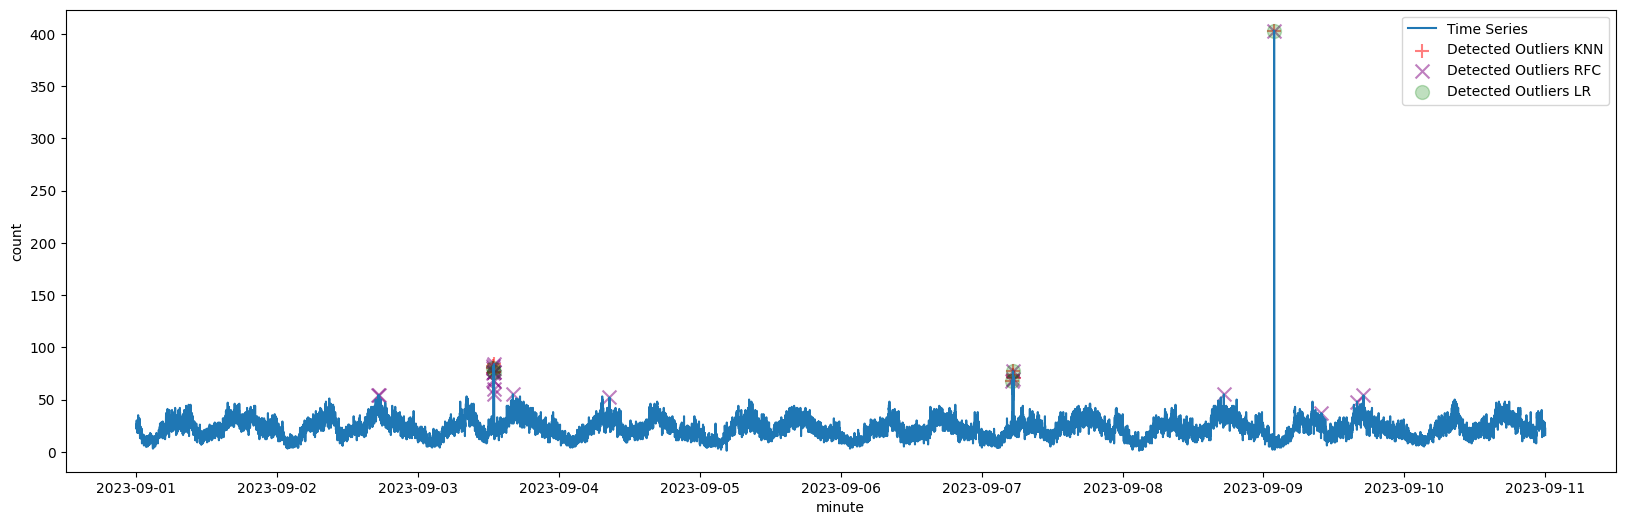

In [71]:
anomalyKNN = df_test.loc[df_test['KNNAnomaly'] == 1, ['timestamp', 'count']]
anomalyLR = df_test.loc[df_test['LRAnomaly'] == 1, ['timestamp', 'count']]
anomalyRFC= df_test.loc[df_test['RFCAnomaly'] == 1, ['timestamp', 'count']]
plt.figure(figsize=(20, 6))
plt.plot(df_test['timestamp'], df_test['count'], label='Time Series')
plt.scatter(anomalyKNN['timestamp'],anomalyKNN['count'], color='red', alpha=0.5, s=100, marker='+', label='Detected Outliers KNN')
plt.scatter(anomalyRFC['timestamp'],anomalyRFC['count'], color='purple', alpha=0.5, s=100, marker='x', label='Detected Outliers RFC')
plt.scatter(anomalyLR['timestamp'],anomalyLR['count'], color='green', alpha=0.25, s=100, label='Detected Outliers LR')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

# Dump

In [117]:
df_test

,minute,count,timestamp,dayOfTheWeek,isWeekend,hours,night,morning,day,difference,LRAnomaly,KNNAnomaly
0,2023-09-01 00:00:00,23,2023-09-01 00:00:00,4,0,0,1,0,0,0.0,0,0
1,2023-09-01 00:01:00,26,2023-09-01 00:01:00,4,0,0,1,0,0,3.0,0,0
2,2023-09-01 00:02:00,22,2023-09-01 00:02:00,4,0,0,1,0,0,-4.0,0,0
3,2023-09-01 00:03:00,26,2023-09-01 00:03:00,4,0,0,1,0,0,4.0,0,0
4,2023-09-01 00:04:00,25,2023-09-01 00:04:00,4,0,0,1,0,0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14395,2023-09-10 23:55:00,25,2023-09-10 23:55:00,6,1,23,0,0,0,7.0,0,0
14396,2023-09-10 23:56:00,23,2023-09-10 23:56:00,6,1,23,0,0,0,-2.0,0,0
14397,2023-09-10 23:57:00,17,2023-09-10 23:57:00,6,1,23,0,0,0,-6.0,0,0
14398,2023-09-10 23:58:00,23,2023-09-10 23:58:00,6,1,23,0,0,0,6.0,0,0
